In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import theano
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


cpu


Set priors

In [51]:
C = 6
J = 2
N = np.array([1000, 100, 30])
S = len(N)

mut_types = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']

# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(J)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(C) * 0.2

Generate data

In [52]:
def encode_counts(X):
    # turn counts of position into word-style encoding
    # https://laptrinhx.com/topic-modeling-with-pymc3-398251916/
    S, C = X.shape
    return [np.repeat(range(C), X[i].astype(int)) for i in range(S)]

In [53]:
## Generate data
#theta_gen = pm.Dirichlet.dist(a=alpha).random(size = S)
#phi_gen = pm.Dirichlet.dist(a=beta, shape=(J, C)).random(size = 1).squeeze()
#X = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, theta_gen@phi_gen)])
#X_encoded = encode_counts(X)

In [54]:
theta_gen = np.array([0.3, 0.7, 0.8, 0.2, .5, .5]).reshape(S, J)
phi_gen = np.array([0.25, 0.6, 0.05, 0.05, 0, 0.05, 1,0,0,0,0,0]).reshape(J, C)
X = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, theta_gen@phi_gen)])
X_encoded = encode_counts(X)

## MCMC vanilla LDA

In [55]:
with pm.Model() as full_model:
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(J, C))
    
    # activities
    theta = pm.Dirichlet("theta", a=alpha, shape=(S, J))
    
    for i in range(S):
        # pick signature for each word
        z = pm.Categorical(f"z_{i}", p=theta[i], shape=X_encoded[i].shape)
        
        # pick word acording to topic probs
        w = pm.Categorical(f"w_{i}", p=phi[z], observed=X_encoded[i])

Fit the model

In [56]:
with full_model:    
    full_trace = pm.sample(1000, return_inferencedata=True, 
                           step=[pm.NUTS([theta, phi], target_accept=0.9),
                                 pm.BinaryGibbsMetropolis([z], transit_p=.7)])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [phi, theta]
>BinaryGibbsMetropolis: [z_2]
>BinaryGibbsMetropolis: [z_0, z_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 527 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7904120568876947, but should be close to 0.9. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6022569187569962, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Sanity check the result

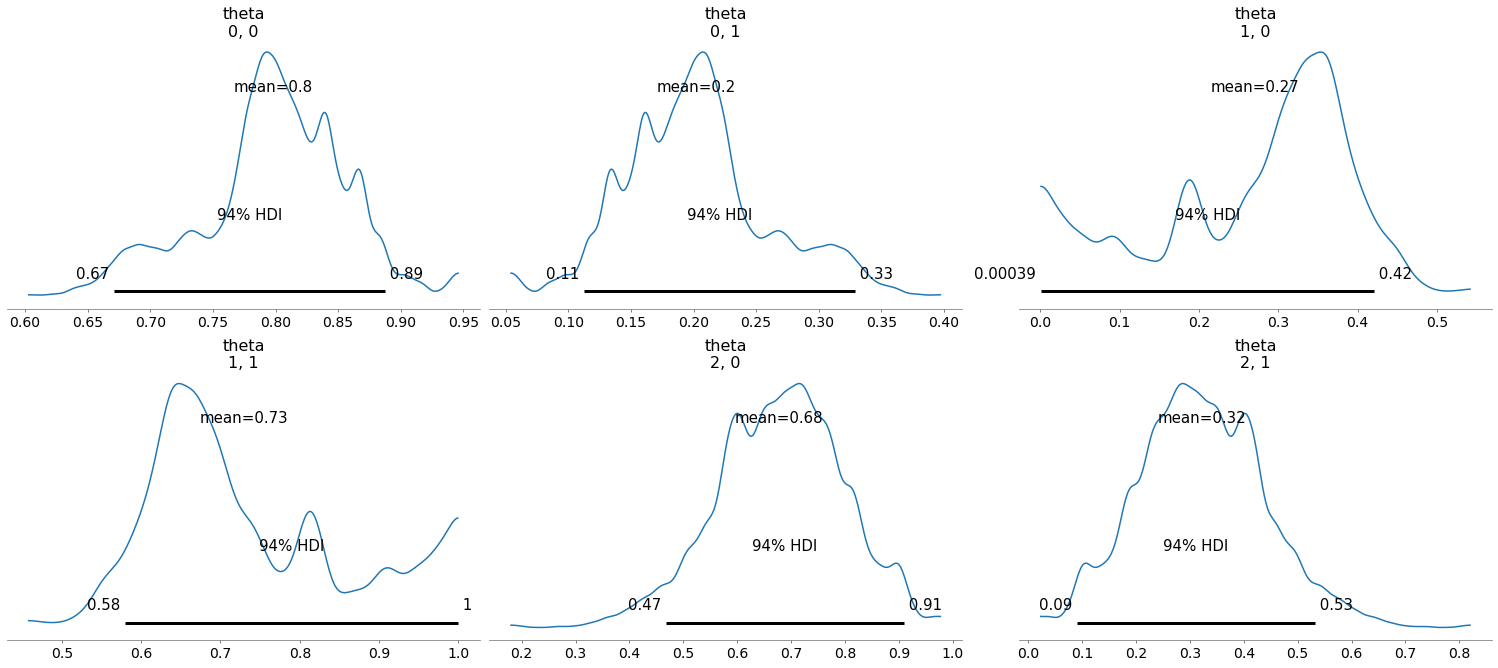

In [57]:
az.plot_posterior(full_trace, var_names=['theta']);

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


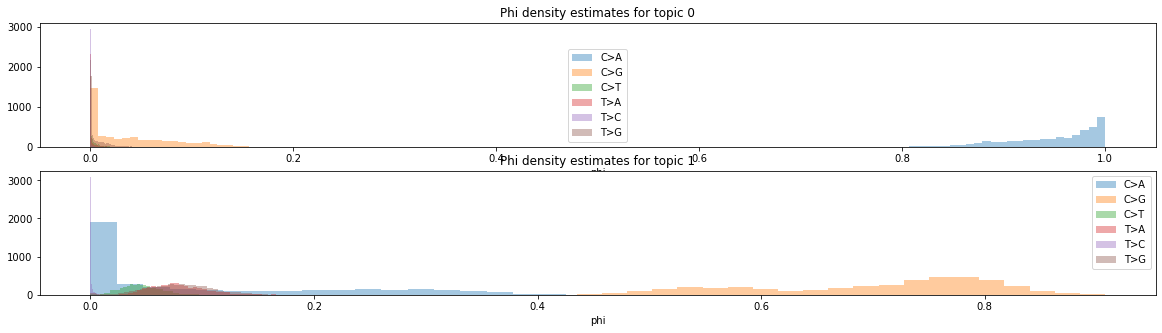

In [58]:
plt.figure(figsize=(20,5))
for j in range(J):
    plt.subplot(2,1,j+1)
    for c in range(C):
        sns.distplot(full_trace.posterior['phi'][:, :, j, c], kde=False, hist=True, label=mut_types[c])
    plt.title(f'Phi density estimates for topic {j}')
    plt.legend(mut_types)

In [59]:
with full_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))



[0.69969457 0.40824829]


## 'collapsed' LDA

In [60]:
with pm.Model() as collapsed_model:

    phi = pm.Dirichlet('phi', a=beta, shape=(J, C))
    theta = pm.Dirichlet("theta", a=alpha, shape=(S, J))
    
    for i in range(S):
        # Words of document
        w = pm.Multinomial(f'sample_{i}', n = N[i], p = theta[i]@phi, observed=X[i])


Fit the model with 

In [61]:
with collapsed_model:
    collapsed_trace = pm.sample(1000, return_inferencedata=True, target_accept=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6684518711285438, but should be close to 0.8. Try to increase the number of tuning steps.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 576 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5876336309738609, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


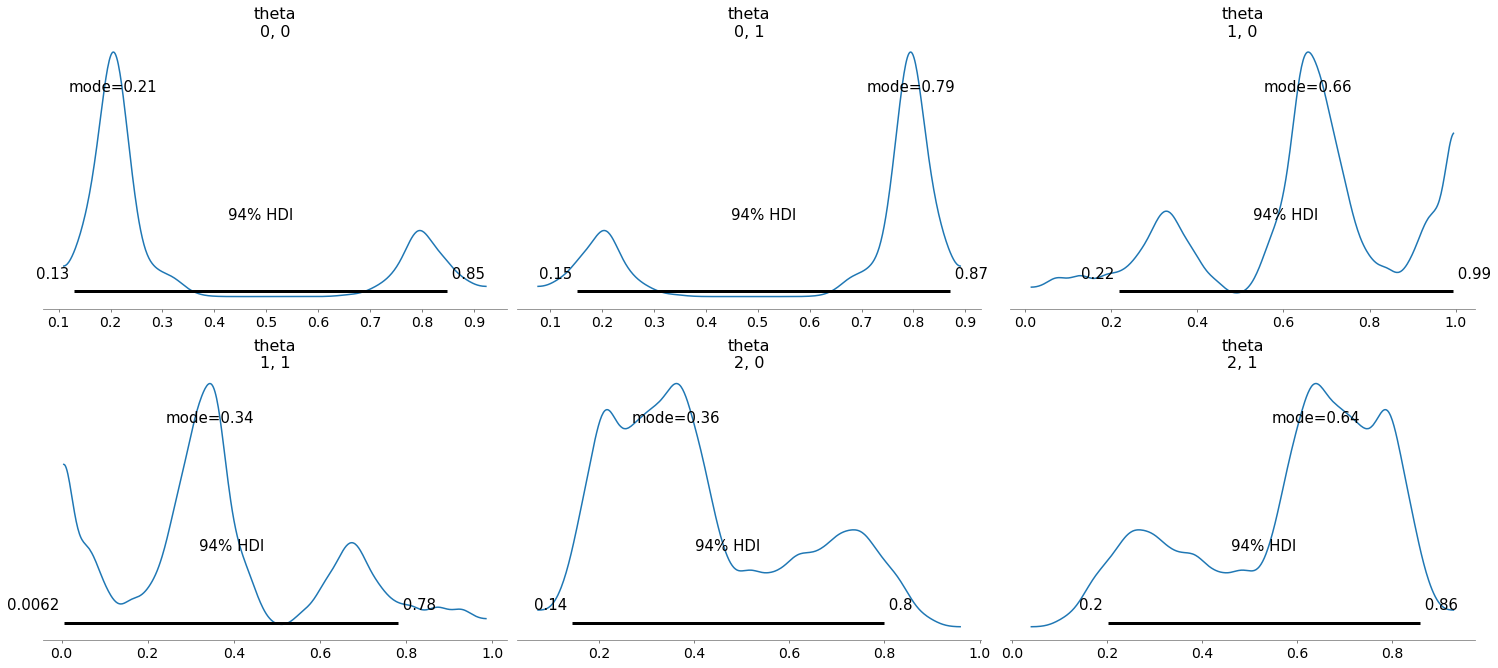

In [130]:
#pm.plot_trace(trace);
#az.plot_forest(collapsed_trace, r_hat=True);
az.plot_posterior(collapsed_trace, var_names=['theta'], point_estimate='mode');

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


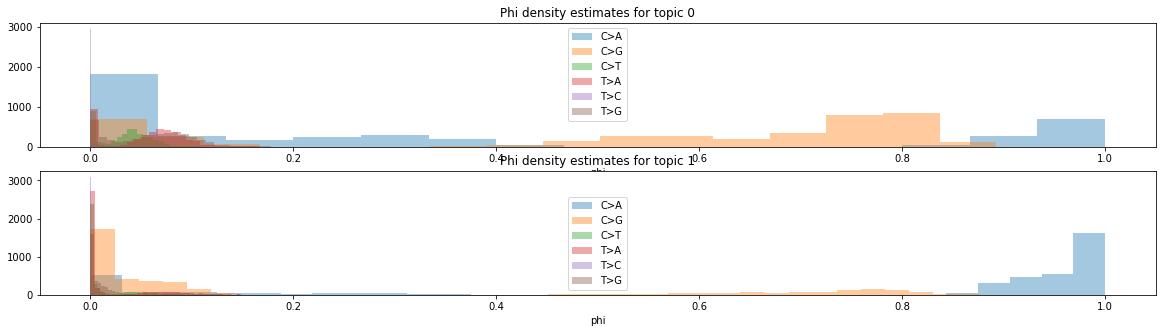

In [63]:
plt.figure(figsize=(20,5))
for j in range(J):
    plt.subplot(2,1,j+1)
    for c in range(C):
        sns.distplot(collapsed_trace.posterior['phi'][:, :, j, c], kde=False, hist=True, label=mut_types[c])
    plt.title(f'Phi density estimates for topic {j}')
    plt.legend(mut_types)

Even though the posterior distributions look okay, seems like the MAP estimate isn't that great... 

In [67]:
np.round(phi_gen, 2)

array([[0.25, 0.6 , 0.05, 0.05, 0.  , 0.05],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [68]:
np.round(theta_gen, 2)

array([[0.3, 0.7],
       [0.8, 0.2],
       [0.5, 0.5]])

In [69]:
with collapsed_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))
    
    theta_map = pm.find_MAP()['theta']
    print(theta_map)


[0.63395053 0.95594353]



[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


On the otherhand, possibly this is the wrong way of accessing the posterior, because the posterior predictive check looks okay https://docs.pymc.io/notebooks/posterior_predictive.html

In [141]:
with collapsed_model:
    ppc = pm.sample_posterior_predictive(
        collapsed_trace, var_names=["phi", "theta", "sample_0", "sample_1", "sample_2"], random_seed=5
    )

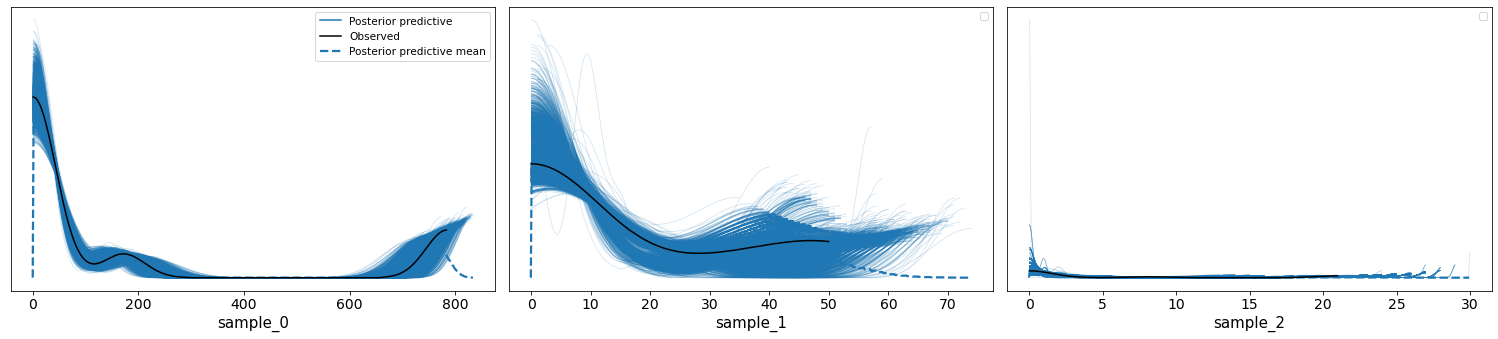

In [142]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=collapsed_model));